## Imports

In [27]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
PATH = "../datasets/filtered-data/"

movies = pd.read_csv(f"{PATH}filtered_movies.csv")
actors = pd.read_csv(f"{PATH}actors_actresses.csv")
crew = pd.read_csv(f"{PATH}filtered_crew.csv")
ratings = pd.read_csv(f"{PATH}filtered_ratings.csv")

## Netttoyer les donnees

In [29]:
print(actors.shape)

# Compter le nombre de films par acteur
actor_film_counts = actors['nconst'].value_counts()

# Filtrer les acteurs ayant joué dans plus de 1 film
actors = actors[actors['nconst'].isin(actor_film_counts[actor_film_counts > 10].index)]
print(actors.shape)

(416137, 4)
(133834, 4)


In [30]:
# Nettoyage des données
movies = movies.dropna(subset=['genres'])
movies['genres'] = movies['genres'].apply(lambda x: x.split(','))
movies = movies[movies["numVotes"] >= 20000]
movies = movies[movies["startYear"] >= 2000]

# Merge des datasets
actors = actors.merge(movies[['tconst', 'primaryTitle', 'genres']], on='tconst')
print(actors.shape)

(26060, 6)


In [31]:
# Pré-calcul des listes d'acteurs pour chaque film
movie_to_actors = defaultdict(list)
for _, row in actors.iterrows():
    movie_to_actors[row['tconst']].append(row['nconst'])

## Creation du graph de cooccurence

In [32]:
# Création des graphes de co-occurrence des acteurs par genre optimisée
def create_cooccurrence_graph(data):
    genre_graphs = defaultdict(nx.Graph)

    for _, row in data.iterrows():
        for genre in row['genres']:
            actor_list = movie_to_actors[row['tconst']]
            for i in range(len(actor_list)):
                for j in range(i + 1, len(actor_list)):
                    actor_i, actor_j = actor_list[i], actor_list[j]
                    if not genre_graphs[genre].has_edge(actor_i, actor_j):
                        genre_graphs[genre].add_edge(actor_i, actor_j, weight=0)
                    genre_graphs[genre][actor_i][actor_j]['weight'] += 1

    return genre_graphs

# Créer les graphes par genre
genre_graphs = create_cooccurrence_graph(movies)

### Stats du graph

In [33]:
# Affichage des statistiques des graphes
for genre, graph in genre_graphs.items():
    print(f"Genre: {genre}")
    print(f"Nombre d'acteurs: {graph.number_of_nodes()}")
    print(f"Nombre d'arêtes: {graph.number_of_edges()}")
    print(f"Degré moyen: {np.mean(list(dict(graph.degree()).values()))}")
    print(f"Clustering moyen: {nx.average_clustering(graph)}")
    print()

Genre: Comedy
Nombre d'acteurs: 2623
Nombre d'arêtes: 23793
Degré moyen: 18.14182234083111
Clustering moyen: 0.5572520754906921

Genre: Fantasy
Nombre d'acteurs: 1294
Nombre d'arêtes: 5272
Degré moyen: 8.1483771251932
Clustering moyen: 0.7866543523978902

Genre: Romance
Nombre d'acteurs: 1872
Nombre d'arêtes: 9620
Degré moyen: 10.277777777777779
Clustering moyen: 0.6900524527900966

Genre: Drama
Nombre d'acteurs: 3320
Nombre d'arêtes: 31799
Degré moyen: 19.156024096385543
Clustering moyen: 0.5078818880908088

Genre: Music
Nombre d'acteurs: 470
Nombre d'arêtes: 1184
Degré moyen: 5.038297872340426
Clustering moyen: 0.8902653325273707

Genre: Adventure
Nombre d'acteurs: 2065
Nombre d'arêtes: 15324
Degré moyen: 14.841646489104116
Clustering moyen: 0.6181004824700351

Genre: Animation
Nombre d'acteurs: 792
Nombre d'arêtes: 3871
Degré moyen: 9.775252525252526
Clustering moyen: 0.7341616232944213

Genre: Action
Nombre d'acteurs: 2706
Nombre d'arêtes: 22376
Degré moyen: 16.538063562453807
Clus

### Plot le graph pour un genre

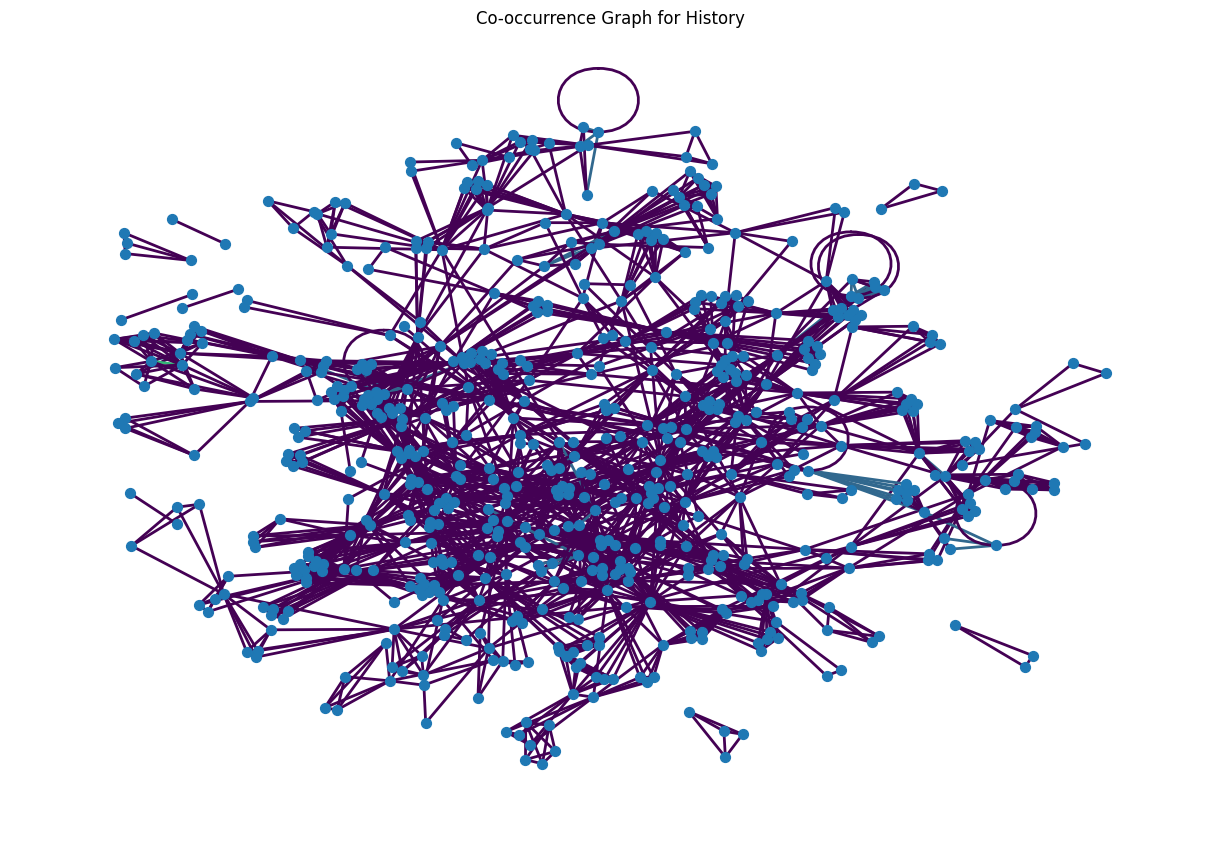

In [37]:
# Visualiser un graphe de co-occurrence
def plot_graph(graph, title):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph, k=0.15)
    weights = nx.get_edge_attributes(graph, 'weight').values()
    nx.draw(graph, pos, node_size=50, font_size=10, edge_color=weights, edge_cmap=plt.cm.viridis, width=2)
    plt.title(title)
    plt.show()

# Exemple de visualisation pour un genre
plot_graph(genre_graphs['History'], 'Co-occurrence Graph for History')

## Calculer les mesures de centralite du graph

In [41]:
import time

# Fonction pour calculer les mesures de centralité
def compute_centrality_measures(graphs):
    centrality_measures = defaultdict(dict)
    for genre, graph in graphs.items():
        start_time = time.time()
        print(f"Calcul des mesures de centralité pour le genre {genre}")

        centrality_measures[genre]['degree'] = nx.degree_centrality(graph)
        degree_time = time.time()
        print(f"Degree centrality done in {degree_time - start_time:.2f} seconds")

        centrality_measures[genre]['closeness'] = nx.closeness_centrality(graph)
        closeness_time = time.time()
        print(f"Closeness centrality done in {closeness_time - degree_time:.2f} seconds")

        centrality_measures[genre]['betweenness'] = nx.betweenness_centrality(graph)
        betweenness_time = time.time()
        print(f"Betweenness centrality done in {betweenness_time - closeness_time:.2f} seconds")

        try:
            centrality_measures[genre]['eigenvector'] = nx.eigenvector_centrality(graph)
            eigenvector_time = time.time()
            print(f"Eigenvector centrality done in {eigenvector_time - betweenness_time:.2f} seconds")
        except nx.PowerIterationFailedConvergence:
            print(f"Eigenvector centrality did not converge for genre {genre}")

        centrality_measures[genre]['pagerank'] = nx.pagerank(graph)
        pagerank_time = time.time()
        print(f"Pagerank centrality done in {pagerank_time - eigenvector_time:.2f} seconds")

        total_time = time.time() - start_time
        print(f"Terminé pour le genre {genre} en {total_time:.2f} seconds")

        print()
        
    return centrality_measures

# Calcul des mesures de centralité
centrality_measures = compute_centrality_measures(genre_graphs)

Calcul des mesures de centralité pour le genre Comedy
Degree centrality done in 0.00 seconds
Closeness centrality done in 15.03 seconds
Betweenness centrality done in 61.76 seconds
Eigenvector centrality done in 0.18 seconds
Pagerank centrality done in 0.06 seconds
Terminé pour le genre Comedy en 77.03 seconds

Calcul des mesures de centralité pour le genre Fantasy
Degree centrality done in 0.00 seconds
Closeness centrality done in 1.56 seconds
Betweenness centrality done in 7.46 seconds
Eigenvector centrality done in 0.23 seconds
Pagerank centrality done in 0.03 seconds
Terminé pour le genre Fantasy en 9.27 seconds

Calcul des mesures de centralité pour le genre Romance
Degree centrality done in 0.00 seconds
Closeness centrality done in 5.17 seconds
Betweenness centrality done in 23.41 seconds
Eigenvector centrality done in 0.15 seconds
Pagerank centrality done in 0.02 seconds
Terminé pour le genre Romance en 28.76 seconds

Calcul des mesures de centralité pour le genre Drama
Degree c

## Acteurs les plus centraux par genre

Genre: Comedy
  degree centrality:
    Actor: nm0136797, Centrality: 0.0591
    Actor: nm0005562, Centrality: 0.0538
    Actor: nm0002071, Centrality: 0.0538
  closeness centrality:
    Actor: nm0005562, Centrality: 0.3980
    Actor: nm0136797, Centrality: 0.3949
    Actor: nm0177896, Centrality: 0.3912
  betweenness centrality:
    Actor: nm0451600, Centrality: 0.1072
    Actor: nm1231899, Centrality: 0.0364
    Actor: nm0177896, Centrality: 0.0339
  eigenvector centrality:
    Actor: nm0136797, Centrality: 0.1404
    Actor: nm0002071, Centrality: 0.1256
    Actor: nm1706767, Centrality: 0.1129
  pagerank centrality:
    Actor: nm0001191, Centrality: 0.0030
    Actor: nm0136797, Centrality: 0.0028
    Actor: nm0005562, Centrality: 0.0026

Genre: Fantasy
  degree centrality:
    Actor: nm0842770, Centrality: 0.0356
    Actor: nm0631490, Centrality: 0.0348
    Actor: nm0000115, Centrality: 0.0333
  closeness centrality:
    Actor: nm0842770, Centrality: 0.3090
    Actor: nm0631490, Cent

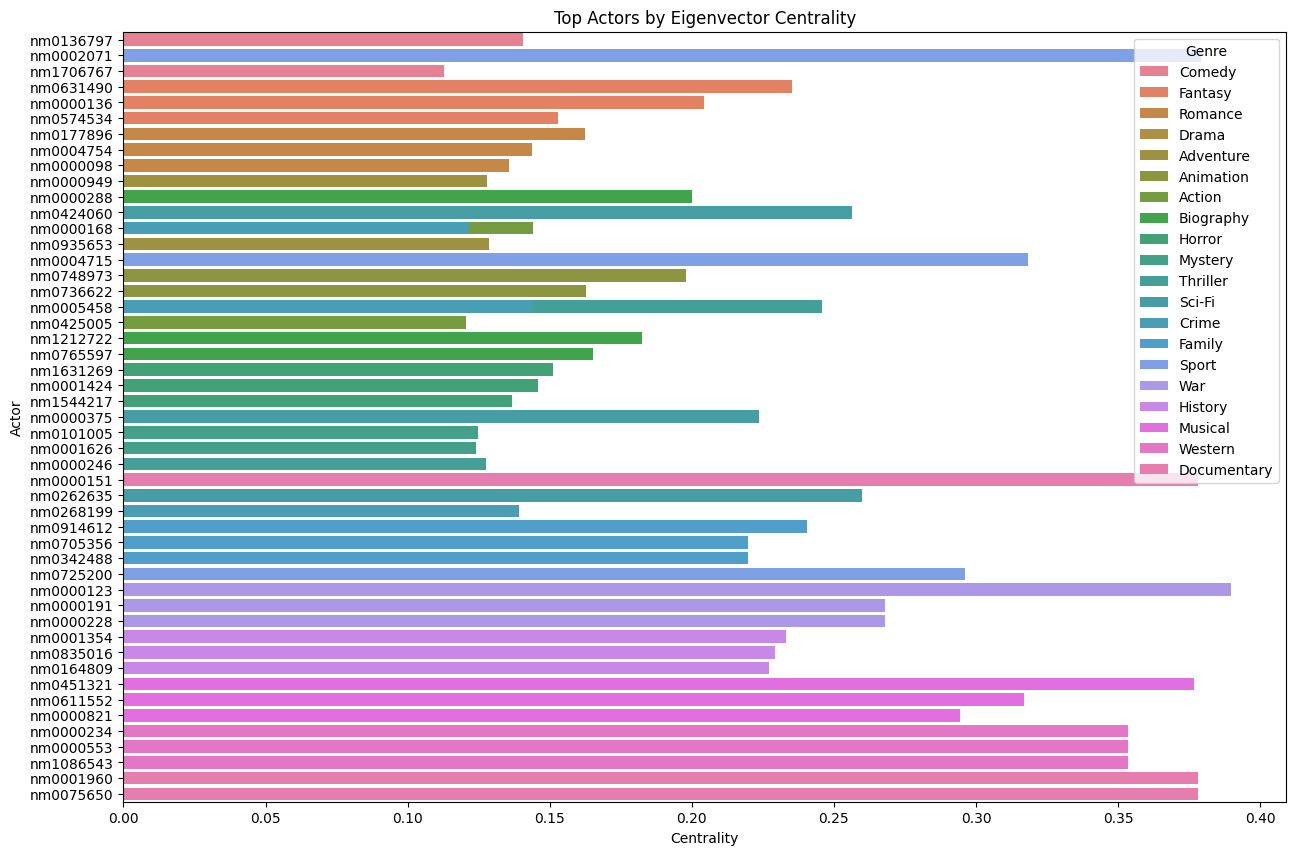

In [57]:
def get_top_central_actors(centrality_measures, top_n=5):
    top_actors = defaultdict(dict)
    for genre, measures in centrality_measures.items():
        for centrality_type, centrality in measures.items():
            # Trier les acteurs par centralité décroissante et prendre les top_n
            sorted_actors = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]
            top_actors[genre][centrality_type] = sorted_actors
    return top_actors

# Obtenir les acteurs les plus centraux pour chaque genre
top_actors = get_top_central_actors(centrality_measures, top_n=3)

# Afficher les acteurs les plus centraux pour chaque genre
for genre, centralities in top_actors.items():
    print(f"Genre: {genre}")
    for centrality_type, actors in centralities.items():
        print(f"  {centrality_type} centrality:")
        for actor, value in actors:
            print(f"    Actor: {actor}, Centrality: {value:.4f}")
    print()

def plot_centrality_bars(top_actors, centrality_type='degree'):
    data = []
    for genre, centralities in top_actors.items():
        if centrality_type in centralities:
            for actor, value in centralities[centrality_type]:
                data.append([genre, actor, value])
    df = pd.DataFrame(data, columns=['Genre', 'Actor', 'Centrality'])

    # Créer des graphiques de barres pour chaque genre
    plt.figure(figsize=(15, 10))
    sns.barplot(x='Centrality', y='Actor', hue='Genre', data=df, dodge=False)
    plt.title(f'Top Actors by {centrality_type.capitalize()} Centrality')
    plt.xlabel('Centrality')
    plt.ylabel('Actor')
    plt.show()

# Exemple de visualisation pour la centralité de degré
plot_centrality_bars(top_actors, centrality_type='eigenvector')

## Calculer la correlation entre la centralite et le succes

In [42]:
# Corrélation entre centralité et succès par genre
def analyze_centrality_success_by_genre(movies, centralities_by_genre):
    correlations = {}
    
    for genre, centralities in centralities_by_genre.items():
        genre_movies = movies[movies['genres'].apply(lambda x: genre in x)]
        for centrality_type, centrality_scores in centralities.items():
            actor_scores = []
            movie_ratings = []
            
            for actor, score in centrality_scores.items():
                actor_movies = genre_movies[genre_movies['tconst'].isin(actors[actors['nconst'] == actor]['tconst'])]
                if not actor_movies.empty:
                    average_rating = actor_movies['averageRating'].mean()
                    actor_scores.append(score)
                    movie_ratings.append(average_rating)
            
            if actor_scores and movie_ratings:
                correlation = np.corrcoef(actor_scores, movie_ratings)[0, 1]
                if genre not in correlations:
                    correlations[genre] = {}
                correlations[genre][centrality_type] = correlation
    
    return correlations

correlations_by_genre = analyze_centrality_success_by_genre(movies, centrality_measures)

/home/victor/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/victor/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Heatmap

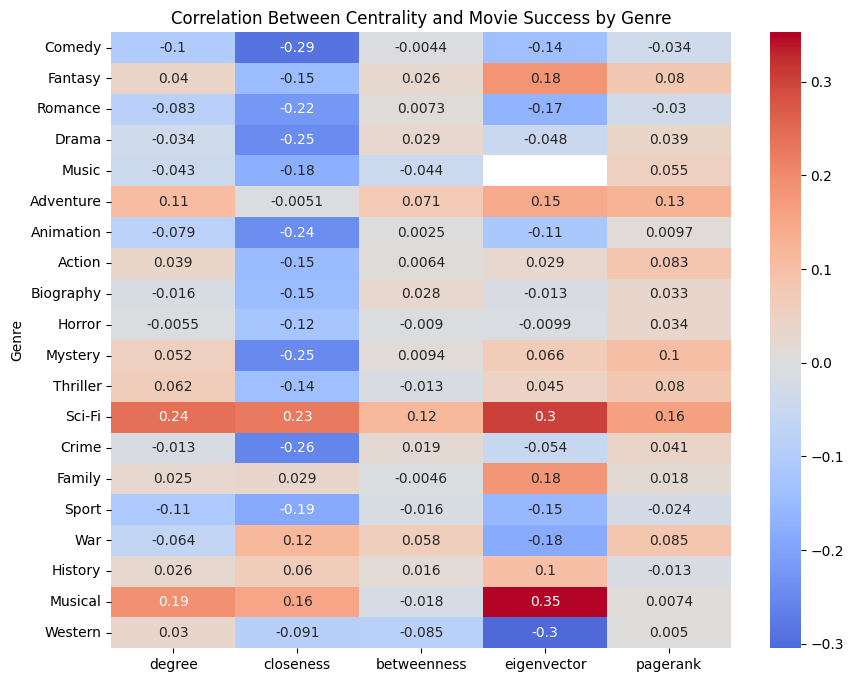

In [46]:
# Convertir les corrélations en DataFrame pour la heatmap
correlations_df = pd.DataFrame(correlations_by_genre).T
correlations_df = correlations_df.drop('Documentary')

# Création de la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations_df, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Centrality and Movie Success by Genre')
plt.ylabel('Genre')
plt.show()